In [210]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio
import noisereduce as nr
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


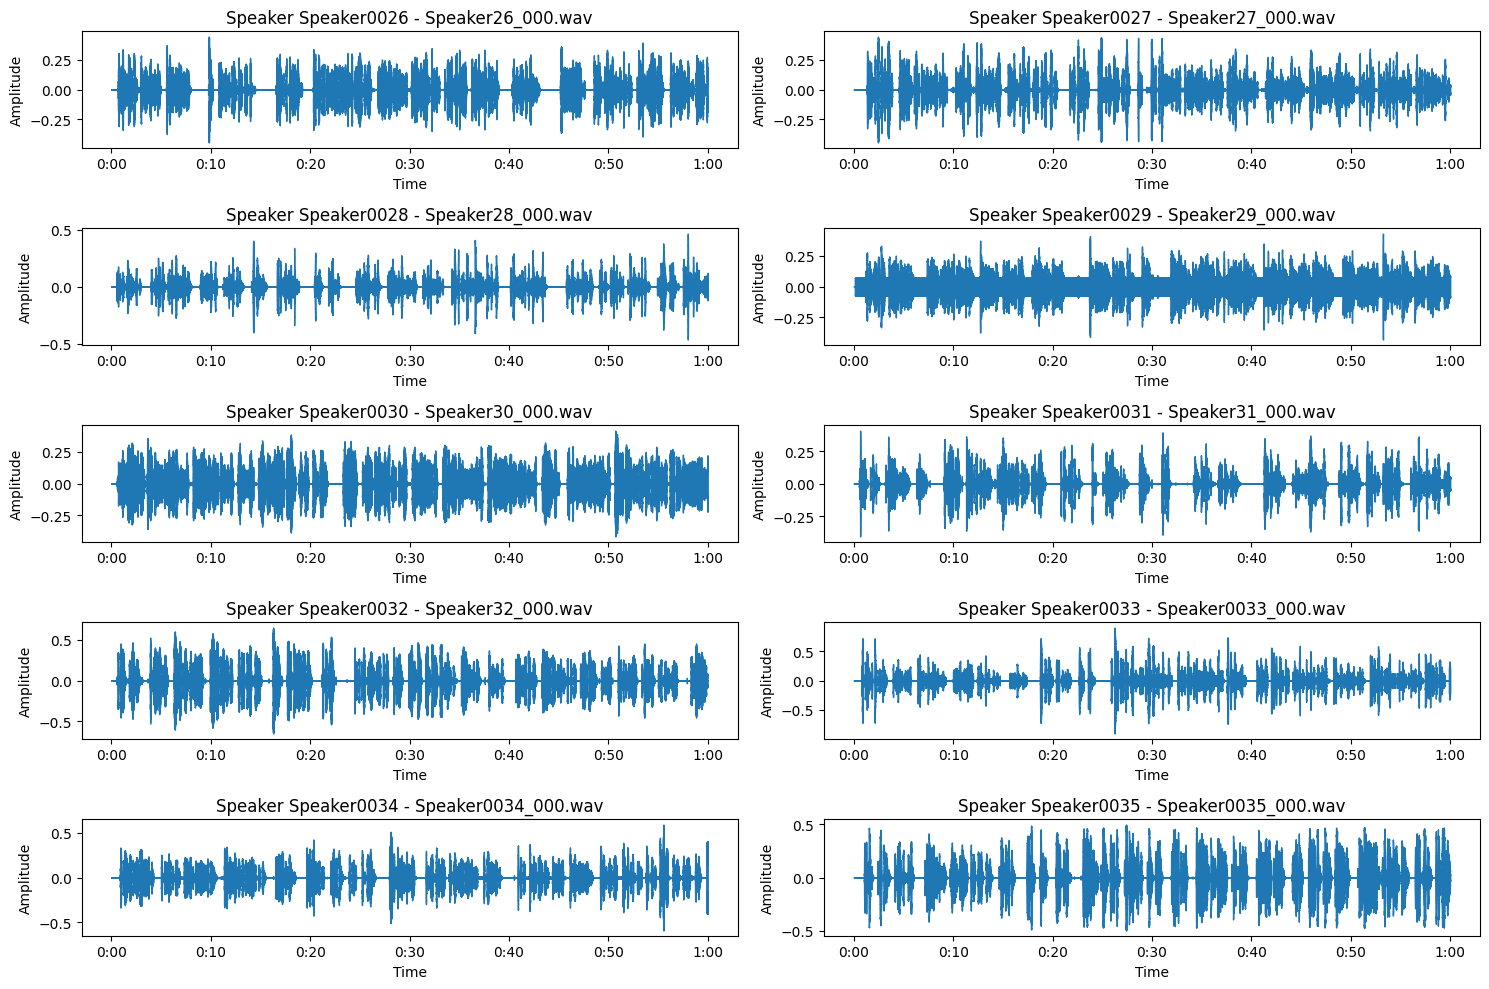

In [ ]:
# Paths 
DATASET_PATH = "50_speakers_audio_data" 
SAMPLE_RATE = 16000 

# Function to visualize 10 random audios from 10 different speakers
def visualize_audio_samples(dataset_path, num_samples=10):
    speaker_folders = sorted(os.listdir(dataset_path))[:num_samples]  
    plt.figure(figsize=(15, 10))
    for i, speaker_folder in enumerate(speaker_folders):
        speaker_path = os.path.join(dataset_path, speaker_folder)
        if os.path.isdir(speaker_path):
            audio_files = [f for f in os.listdir(speaker_path) if f.endswith(".wav")]
            if audio_files:
                file_path = os.path.join(speaker_path, audio_files[0])  
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                plt.subplot(5, 2, i+1)
                librosa.display.waveshow(y, sr = sr)
                plt.title(f"Speaker {speaker_folder} - {audio_files[0]}")
                plt.xlabel("Time")
                plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

visualize_audio_samples(DATASET_PATH)

In [ ]:
# Parameters 

SAMPLE_RATE = 16000
N_MFCC = 40

# Function to preprocess audio
def preprocess_audio(y, sr):
    
    y = nr.reduce_noise(y=y, sr=sr) # Noise reduction
    y = librosa.effects.preemphasis(y) # Apply pre-emphasis filter
    y = librosa.util.normalize(y) # Normalize audio
    y, _ = librosa.effects.trim(y) # Trim silence
    
    return y

# Function to extract MFCC features 
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

    y = preprocess_audio(y, sr)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC) # Extract MFCC features
     
    return mfccs.T  

# Collect data
features, labels = [], []
for speaker_id, speaker_folder in enumerate(sorted(os.listdir(DATASET_PATH))):
    id = speaker_folder[-2::]
    if id[0] == '0':
        id = id[1]
    
    speaker_path = os.path.join(DATASET_PATH, speaker_folder)
    if os.path.isdir(speaker_path):
        for file in tqdm(os.listdir(speaker_path), desc=f"Processing speaker {id}"):
            if file.endswith( ".wav"):
                file_path = os.path.join(speaker_path, file)
                try:
                    feature_matrix = extract_features(file_path)
                    features.append(feature_matrix)  
                    labels.append(id)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")




Processing speaker 26:   0%|          | 0/45 [00:00<?, ?it/s]

Processing speaker 2:  99%|█████████▉| 119/120 [01:06<00:00,  1.77it/s]c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\noisereduce\spectralgate\nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
Processing speaker 2: 100%|██████████| 120/120 [01:06<00:00,  1.80it/s]


Error processing 50_speakers_audio_data\Speaker_0002\Speaker_0002_00119.wav: Input must be finite


Processing speaker 3: 100%|██████████| 85/85 [00:47<00:00,  1.79it/s]


Error processing 50_speakers_audio_data\Speaker_0003\Speaker_0003_00084.wav: Input must be finite


Processing speaker 9:  98%|█████████▊| 64/65 [00:36<00:00,  1.68it/s]c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(
Processing speaker 13: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]


Error processing 50_speakers_audio_data\Speaker_0013\Speaker_0013_00036.wav: Input must be finite


Processing speaker 25: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s]


In [214]:
max_seq_length = 0
for i in features:
    if i.shape[0] > max_seq_length:
        max_seq_length = max(max_seq_length, i.shape[0])

print(max_seq_length)

1877


In [ ]:
# Padding mfcc features so that every audio features are of same shape

def pad_mfcc_features(mfcc_features, max_seq_length=max_seq_length):
    padded_features = []
    for mfcc in mfcc_features:
        if mfcc.shape[0] > max_seq_length:
            mfcc = mfcc[:max_seq_length, :]
        else:
            pad_width = max_seq_length - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        padded_features.append(mfcc)
    return np.array(padded_features)

padded_features = pad_mfcc_features(features)

# Updating labels according to the dataset
updated_labels = []

for i in range(len(labels)):
    updated_labels.append(int(labels[i]))
    if updated_labels[i] > 21:
        updated_labels[i] = updated_labels[i] - 1


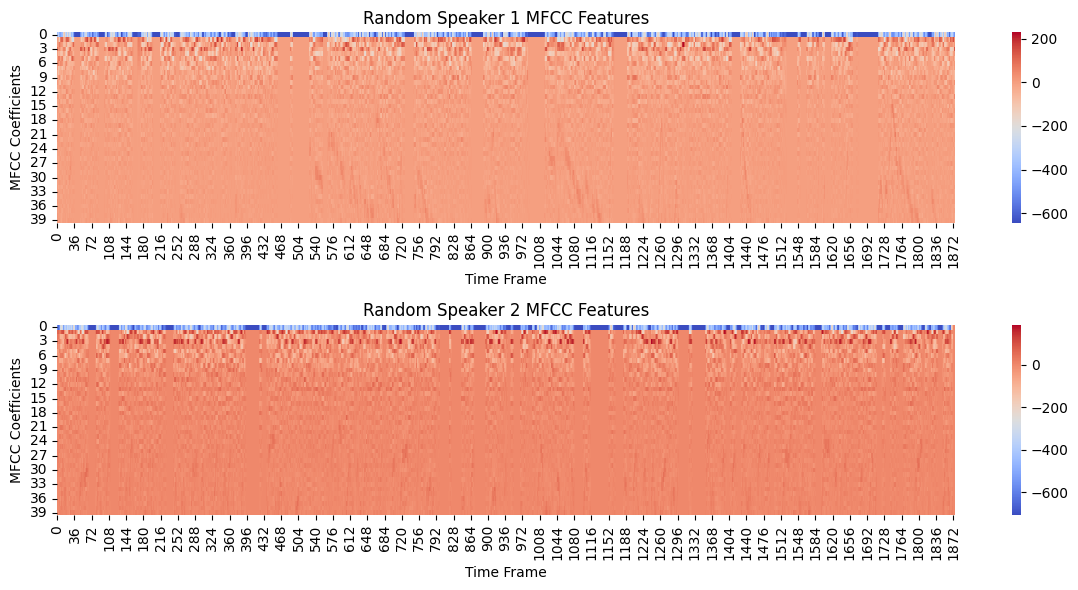

In [ ]:
import random

# Function comparing MFCC features of two random audios

def compare_random_features():
    if len(padded_features) < 2:
        print("Not enough data to compare features.")
        return
    
    idx1, idx2 = random.sample(range(len(padded_features)), 2)
    feature1, feature2 = padded_features[idx1], padded_features[idx2]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    sns.heatmap(feature1.T, cmap='coolwarm', cbar=True)
    plt.title("Random Speaker 1 MFCC Features")
    plt.xlabel("Time Frame")
    plt.ylabel("MFCC Coefficients")
    
    plt.subplot(2, 1, 2)
    sns.heatmap(feature2.T, cmap='coolwarm', cbar=True)
    plt.title("Random Speaker 2 MFCC Features")
    plt.xlabel("Time Frame")
    plt.ylabel("MFCC Coefficients")
    
    plt.tight_layout()
    plt.show()

compare_random_features()

In [220]:
# Convert lists to arrays with float32 dtype for GPU
final_features = np.array(padded_features, dtype=np.float32)
final_labels = np.array(updated_labels)

In [222]:
print("MLCC_features:")
print("Shape:" ,final_features.shape)
print("Type:", type(final_features))
print("Dtype:" ,final_features.dtype)

print("\nLabels")
print("Shape:", final_labels.shape)
print("Type:", type(final_labels))
print("Dtype:", final_labels.dtype)

MLCC_features:
Shape: (2508, 1877, 40)
Type: <class 'numpy.ndarray'>
Dtype: float32

Labels
Shape: (2508,)
Type: <class 'numpy.ndarray'>
Dtype: int32


In [ ]:
# Load MLCC features and labels
mlcc_features = torch.tensor(final_features, dtype=torch.float32)  # (2508, 1877, 40)
labels = torch.tensor(final_labels, dtype=torch.long)  # (2508,)

In [224]:
print("MLCC_features:")
print("Shape:" ,mlcc_features.shape)
print("Type:", type(mlcc_features))
print("Dtype:" ,mlcc_features.dtype)

print("\nLabels")
print("Shape:", labels.shape)
print("Type:", type(labels))
print("Dtype:", labels.dtype)

MLCC_features:
Shape: torch.Size([2508, 1877, 40])
Type: <class 'torch.Tensor'>
Dtype: torch.float32

Labels
Shape: torch.Size([2508])
Type: <class 'torch.Tensor'>
Dtype: torch.int64


In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

In [226]:
# Split dataset into train, validation, and test sets
data_size = len(mlcc_features)
train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(TensorDataset(mlcc_features, labels), [train_size, val_size, test_size])



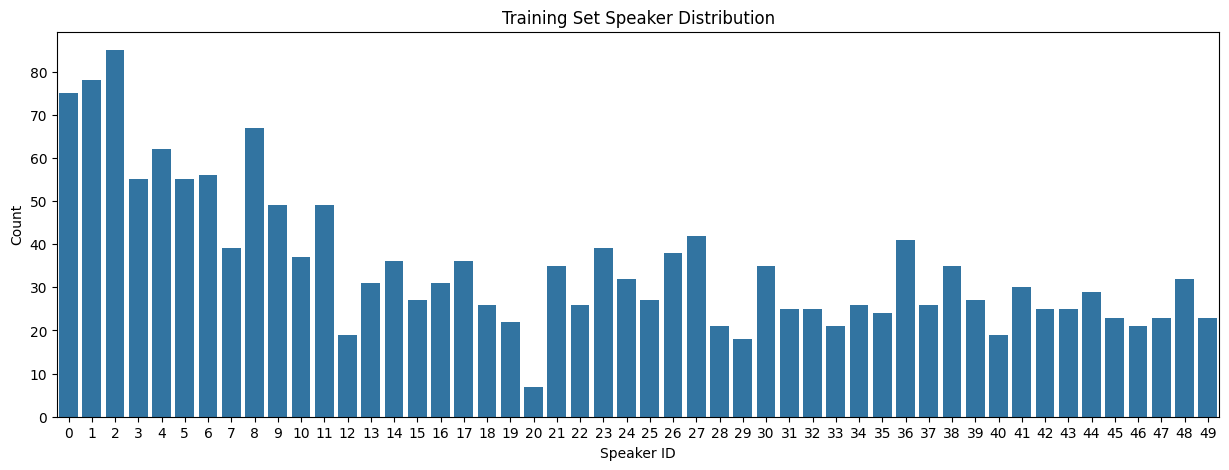

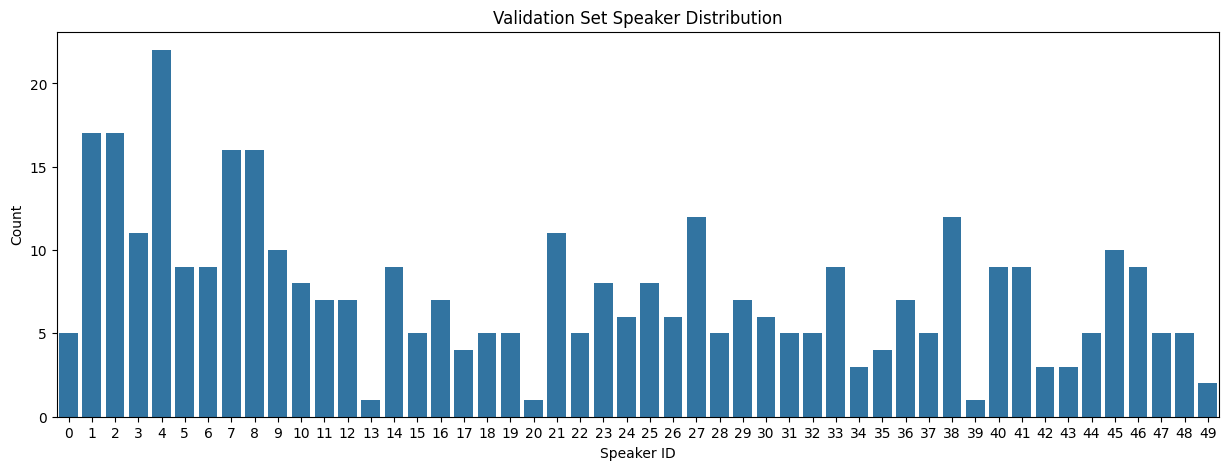

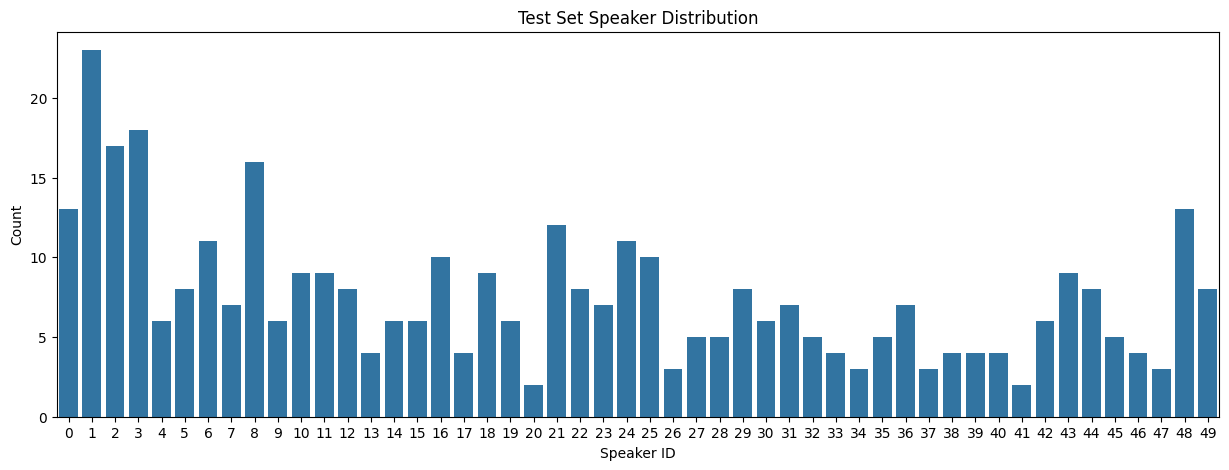

In [ ]:
# Exploratory Data Analysis (EDA)

def plot_class_distribution(y, title):
    plt.figure(figsize=(15, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Speaker ID")
    plt.ylabel("Count")
    plt.show()

# Plot class distributions of the labels 
plot_class_distribution([int(train_dataset[i][1]) for i in range(len(train_dataset))], "Training Set Speaker Distribution")
plot_class_distribution([int(val_dataset[i][1]) for i in range(len(val_dataset))], "Validation Set Speaker Distribution")
plot_class_distribution([int(test_dataset[i][1]) for i in range(len(test_dataset))], "Test Set Speaker Distribution")



In [ ]:
# Hyperparameters
input_size = 40
hidden_size = 128  
num_layers = 3  
dropout = 0.2  
num_classes = 50
batch_size = 32
epochs = 30 
learning_rate = 0.001
weight_decay = 1e-5  # L2 regularization


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Define Bidirectional-LSTM model

lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout).to(device)
linear_layer = nn.Linear(hidden_size * 2, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(lstm_layer.parameters()) + list(linear_layer.parameters()), lr=learning_rate, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate decay

# Training loop
losses = []
val_losses = []
for epoch in range(epochs):
    lstm_layer.train()
    linear_layer.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
        lstm_out, _ = lstm_layer(inputs)  # Extract LSTM output  
        outputs = linear_layer(lstm_out[:, -1, :]) # Use last time step
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    scheduler.step()
    
    # Validation loss
    lstm_layer.eval()
    linear_layer.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            lstm_out, _ = lstm_layer(inputs)
            outputs = linear_layer(lstm_out[:, -1, :])
            val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_losses[-1]:.4f}")

print("Training complete!")

Epoch 1/30:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]


Epoch [1/30], Loss: 3.3397, Val Loss: 3.2749


Epoch 2/30: 100%|██████████| 55/55 [00:08<00:00,  6.55it/s]


Epoch [2/30], Loss: 2.5032, Val Loss: 2.6911


Epoch 3/30: 100%|██████████| 55/55 [00:08<00:00,  6.56it/s]


Epoch [3/30], Loss: 2.6891, Val Loss: 2.4574


Epoch 4/30: 100%|██████████| 55/55 [00:08<00:00,  6.58it/s]


Epoch [4/30], Loss: 2.3198, Val Loss: 2.2729


Epoch 5/30: 100%|██████████| 55/55 [00:08<00:00,  6.54it/s]


Epoch [5/30], Loss: 1.6083, Val Loss: 1.8925


Epoch 6/30: 100%|██████████| 55/55 [00:08<00:00,  6.54it/s]


Epoch [6/30], Loss: 1.6054, Val Loss: 1.8797


Epoch 7/30: 100%|██████████| 55/55 [00:08<00:00,  6.30it/s]


Epoch [7/30], Loss: 1.8403, Val Loss: 1.7010


Epoch 8/30: 100%|██████████| 55/55 [00:08<00:00,  6.31it/s]


Epoch [8/30], Loss: 1.0617, Val Loss: 1.4032


Epoch 9/30: 100%|██████████| 55/55 [00:08<00:00,  6.30it/s]


Epoch [9/30], Loss: 1.2357, Val Loss: 1.2924


Epoch 10/30: 100%|██████████| 55/55 [00:08<00:00,  6.55it/s]


Epoch [10/30], Loss: 1.1636, Val Loss: 1.1874


Epoch 11/30: 100%|██████████| 55/55 [00:08<00:00,  6.57it/s]


Epoch [11/30], Loss: 0.7643, Val Loss: 1.0637


Epoch 12/30: 100%|██████████| 55/55 [00:08<00:00,  6.28it/s]


Epoch [12/30], Loss: 0.9824, Val Loss: 0.9866


Epoch 13/30: 100%|██████████| 55/55 [00:08<00:00,  6.28it/s]


Epoch [13/30], Loss: 0.7532, Val Loss: 0.8939


Epoch 14/30: 100%|██████████| 55/55 [00:08<00:00,  6.26it/s]


Epoch [14/30], Loss: 0.5456, Val Loss: 0.8325


Epoch 15/30: 100%|██████████| 55/55 [00:08<00:00,  6.27it/s]


Epoch [15/30], Loss: 0.8333, Val Loss: 0.8286


Epoch 16/30: 100%|██████████| 55/55 [00:08<00:00,  6.25it/s]


Epoch [16/30], Loss: 0.5673, Val Loss: 0.7793


Epoch 17/30: 100%|██████████| 55/55 [00:08<00:00,  6.22it/s]


Epoch [17/30], Loss: 0.5360, Val Loss: 0.8748


Epoch 18/30: 100%|██████████| 55/55 [00:08<00:00,  6.23it/s]


Epoch [18/30], Loss: 0.6491, Val Loss: 0.7409


Epoch 19/30: 100%|██████████| 55/55 [00:08<00:00,  6.18it/s]


Epoch [19/30], Loss: 0.6212, Val Loss: 0.7611


Epoch 20/30: 100%|██████████| 55/55 [00:08<00:00,  6.16it/s]


Epoch [20/30], Loss: 0.4769, Val Loss: 0.8098


Epoch 21/30: 100%|██████████| 55/55 [00:08<00:00,  6.16it/s]


Epoch [21/30], Loss: 0.5395, Val Loss: 0.6989


Epoch 22/30: 100%|██████████| 55/55 [00:08<00:00,  6.13it/s]


Epoch [22/30], Loss: 0.6096, Val Loss: 0.6734


Epoch 23/30: 100%|██████████| 55/55 [00:09<00:00,  6.10it/s]


Epoch [23/30], Loss: 0.5531, Val Loss: 0.6949


Epoch 24/30: 100%|██████████| 55/55 [00:09<00:00,  6.10it/s]


Epoch [24/30], Loss: 0.2947, Val Loss: 0.6630


Epoch 25/30: 100%|██████████| 55/55 [00:09<00:00,  6.07it/s]


Epoch [25/30], Loss: 0.3295, Val Loss: 0.6676


Epoch 26/30: 100%|██████████| 55/55 [00:09<00:00,  6.07it/s]


Epoch [26/30], Loss: 0.2451, Val Loss: 0.6743


Epoch 27/30: 100%|██████████| 55/55 [00:09<00:00,  6.04it/s]


Epoch [27/30], Loss: 0.2375, Val Loss: 0.6275


Epoch 28/30: 100%|██████████| 55/55 [00:09<00:00,  6.07it/s]


Epoch [28/30], Loss: 0.4969, Val Loss: 0.6120


Epoch 29/30: 100%|██████████| 55/55 [00:09<00:00,  6.01it/s]


Epoch [29/30], Loss: 0.4424, Val Loss: 0.5931


Epoch 30/30: 100%|██████████| 55/55 [00:09<00:00,  6.08it/s]


Epoch [30/30], Loss: 0.1672, Val Loss: 0.6032
Training complete!


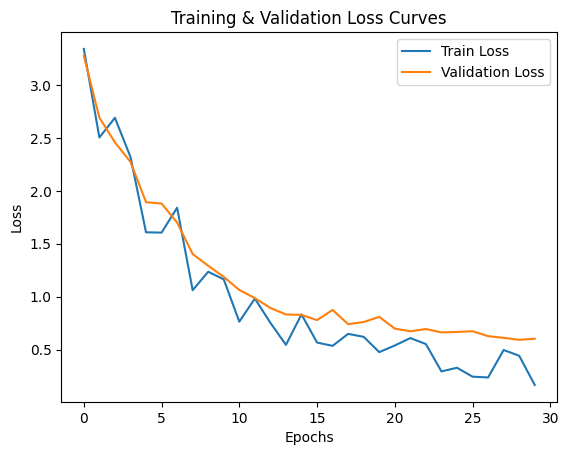

In [ ]:
# Plot loss curves

plt.plot(range(epochs), losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
# Evaluating model performance using relevant metrices

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true, y_pred = [], []
lstm_layer.eval()
linear_layer.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Evaluating"):
        inputs, targets = inputs.to(device), targets.to(device)
        lstm_out, _ = lstm_layer(inputs)
        outputs = linear_layer(lstm_out[:, -1, :])
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")



Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]

Test Accuracy: 0.8249
Precision: 0.8530
Recall: 0.8249
F1 Score: 0.8217


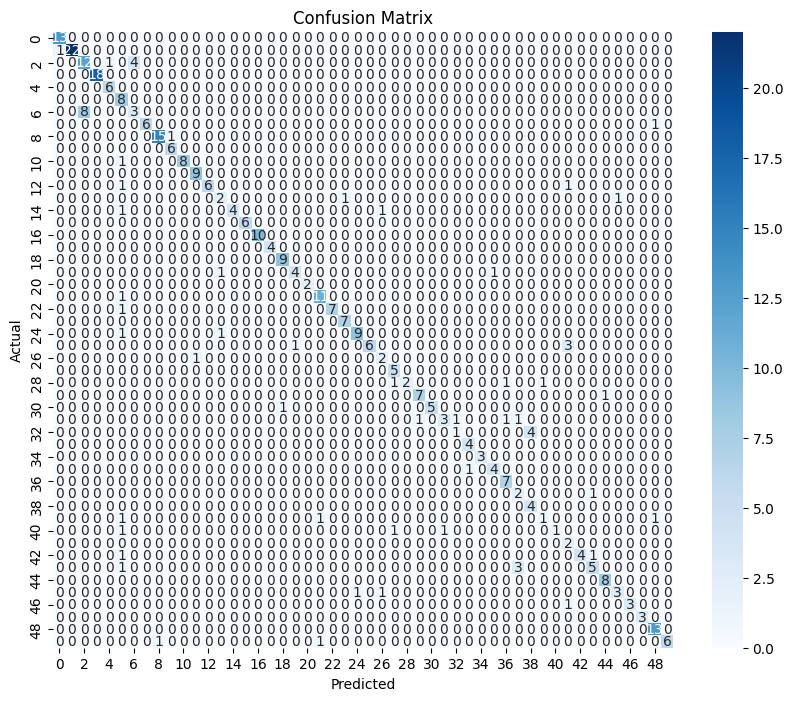

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Original and Predicted labels of 20 audios

for i in range(0, 20):
    print(f"Actual Output: {y_true[i]} Predicted Output: {y_pred[i]}")

Actual Output: 3 Predicted Output: 3
Actual Output: 3 Predicted Output: 3
Actual Output: 6 Predicted Output: 2
Actual Output: 29 Predicted Output: 29
Actual Output: 44 Predicted Output: 44
Actual Output: 48 Predicted Output: 48
Actual Output: 5 Predicted Output: 5
Actual Output: 18 Predicted Output: 18
Actual Output: 1 Predicted Output: 1
Actual Output: 45 Predicted Output: 26
Actual Output: 0 Predicted Output: 0
Actual Output: 10 Predicted Output: 10
Actual Output: 8 Predicted Output: 8
Actual Output: 15 Predicted Output: 15
Actual Output: 18 Predicted Output: 18
Actual Output: 32 Predicted Output: 38
Actual Output: 13 Predicted Output: 45
Actual Output: 8 Predicted Output: 8
Actual Output: 21 Predicted Output: 21
Actual Output: 5 Predicted Output: 5


In [ ]:
# Test on new data 

def test_model(new_data):
    new_data = torch.tensor(new_data, dtype=torch.float32).to(device)
    with torch.no_grad():
        lstm_out, _ = lstm_layer(new_data)
        outputs = linear_layer(lstm_out[:, -1, :])
        _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()

new_sample = torch.randn(1, 1877, 40).to(device)
print("Predicted Speaker:", test_model(new_sample))

Predicted Speaker: [5]


C:\Users\harsh\AppData\Local\Temp\ipykernel_18172\3324474629.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_data = torch.tensor(new_data, dtype=torch.float32).to(device)
